In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('./dialects_database.db')
cursor = conn.cursor()

cursor.execute("SELECT * FROM id_text")
text = cursor.fetchall()
text_df = pd.DataFrame(text, columns=['id', 'tweet'])

cursor.execute("SELECT * FROM id_dialect")
dialect = cursor.fetchall()
dialect_df = pd.DataFrame(dialect, columns=['id', 'dialect'])

cursor.close()
conn.close()

df = pd.merge(text_df, dialect_df, on="id")
df.drop(['id'], axis=1, inplace=True)
df.head()

,tweet,dialect
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY


In [2]:
num_duplicates = df.duplicated().sum()
print('Number of duplicates:', num_duplicates)

Number of duplicates: 0


In [3]:
class_counts = df['dialect'].value_counts()
class_proportions = df['dialect'].value_counts(normalize=True)

print('Class counts:')
print(class_counts)

print('Class proportions:')
print(class_proportions)

Class counts:
EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: dialect, dtype: int64
Class proportions:
EG    0.390157
LY    0.247074
LB    0.186949
SD    0.097709
MA    0.078111
Name: dialect, dtype: float64


In [6]:
import nltk
from nltk.tokenize import TweetTokenizer

def tokenize_tweet(tweet):
    # create a TweetTokenizer object
    tknzr = TweetTokenizer()
    # tokenize the tweet
    tokens = tknzr.tokenize(tweet)
    return tokens
tokenized = tokenize_tweet(df['tweet'][0])

In [7]:
def remove_extra_spaces(words):
    """Removes extra whitespaces at the beginning and at the end of each word in a list"""
    cleaned_words = []
    for word in words:
        cleaned_word = ' '.join(word.split()).strip()
        cleaned_words.append(cleaned_word)
    return cleaned_words
r_e_s = remove_extra_spaces(tokenized)

In [8]:
import re

def remove_urls(lst):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return [re.sub(pattern, '', item).strip() for item in lst if re.sub(pattern, '', item).strip() != '']
r_urls = remove_urls(r_e_s)

In [9]:
def remove_user_mentions(words):
    """Removes user mentions (@user) from a list of words"""
    cleaned_words = []
    for word in words:
        if not word.startswith('@'):
            cleaned_words.append(word)
    return cleaned_words
r_u_m = remove_user_mentions(r_urls)

In [10]:
import string

def remove_punctuation(lst):
    """Removes punctuation from a list of strings, including single punctuation characters"""
    translator = str.maketrans('', '', string.punctuation+'؟')
    result = []
    for item in lst:
        # Remove all punctuation characters
        item = item.translate(translator)
        # Remove any remaining single punctuation characters
        if item != '':
          result.append(item)
    return result
r_p = remove_punctuation(r_u_m)

In [11]:
def remove_numbers(lst):
    """Removes numbers from a list of strings"""
    pattern = re.compile(r'\d+')
    return [re.sub(pattern, '', item) for item in lst if re.sub(pattern, '', item).strip() != '']
r_n = remove_numbers(r_p)

In [12]:
import emoji
def remove_emojis(words):
    """Removes emojis from a list of words"""
    cleaned_words = []
    for word in words:
        cleaned_word = ''.join(c for c in word if c not in emoji.EMOJI_DATA)
        if cleaned_word != '':
            cleaned_words.append(cleaned_word)
    return cleaned_words
r_e = remove_emojis(r_n)

In [13]:
def remove_foreign_language(lst):
    pattern = re.compile(r'[^\u0600-\u06ff]+')
    return [re.sub(pattern, "", item) for item in lst if re.sub(pattern, "", item) != '']

r_f_l = remove_foreign_language(r_e)

In [14]:
from pyarabic.araby import strip_tashkeel
from pyarabic.araby import normalize_ligature
def remove_tashkeel(lst):
    return [normalize_ligature(strip_tashkeel(word)) for word in lst]
r_t = remove_tashkeel(r_f_l)

In [15]:
def remove_repeated_chars(lst):
    pattern = re.compile(r"(\w)\1{2,}")
    return [re.sub(pattern, r"\1\1", item).strip() for item in lst if re.sub(pattern, '', item).strip() != '']

r_r_c = remove_repeated_chars(r_t)

In [16]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [17]:
STOP_WORDS = set(nltk.corpus.stopwords.words("arabic"))

def remove_stop_words(lst):
    result = []
    for word in lst:
        if word not in STOP_WORDS:
            result.append(word)
    return result
r_s_w = remove_stop_words(r_r_c)

In [18]:
def form_sentence(words):
    """Forms a sentence from a list of words"""
    sentence = ' '.join(words)
    return sentence
f_s = form_sentence(r_s_w)

In [19]:
def clean_tweet(tweet):
    """
    A function to clean a single tweet.
    """
    #tokenize tweet 
    words = tokenize_tweet(tweet)
    #remove extra white-spaces
    words = remove_extra_spaces(words)
    #remove urls 
    words = remove_urls(words)
    #remove user mentions 
    words = remove_user_mentions(words)
    #remove punctiation
    words = remove_punctuation(words)
    #remove numbers
    words = remove_numbers(words)
    #remove emojis
    words = remove_emojis(words)
    #remove non-arabic charachters
    words = remove_foreign_language(words)
    #remove tashkeel 
    words = remove_tashkeel(words)
    #remove repeated charachters
    words = remove_repeated_chars(words)
    #remove stop words 
    words = remove_stop_words(words)
    #form a new sentence
    sentence = form_sentence(words)
    
    return sentence 

In [20]:
from tqdm import tqdm

df['clean_tweet'] = tqdm(df['tweet'].apply(clean_tweet))
df.head(10)

100%|██████████████████████████████| 147725/147725 [00:00<00:00, 4003719.11it/s]


,tweet,dialect,clean_tweet
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY,الليبيين متقلبين بالنسبة ليا انا ميليشياوي زما...
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY,تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها ...
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY,رانيا عقليتك متخلفة اولا الانسان يلي يحتاج اهل...
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY,شكلك متعقدة علشان الراجل تحبيه ازوج بنت يتيمة ...
5,@alibobkr63 او حتى من اي دين او طائفة. اسف ممك...,LY,او اي دين او طائفة اسف ممكن الغلط غلطتي مكنش قصدي
6,@muhamed01111 باهي نستنوه. بلكي مشغول ولا حاجة,LY,باهي نستنوه بلكي مشغول حاجة
7,@muhamed01111 مهما اختلفنا راه نحنا خوت. والله...,LY,اختلفنا راه نحنا خوت والله عندي انا فرحان نقدر...
8,@muhamed01111 بالنسبة ليا انا والله شبعت هم ون...,LY,بالنسبة ليا انا والله شبعت ونكد وقتل ودم والحق...
9,@Ajo32asLibya @Jed_ly مو نحنا الحياة عندنا مية...,LY,مو نحنا الحياة عندنا مية مية ومعندش شي اندكوا ...


In [21]:
import numpy as np 

df.clean_tweet = df.clean_tweet.replace('',np.NaN)
print(df['clean_tweet'].isnull().values.sum())

df.dropna(inplace=True)

73


In [22]:
df = df[['clean_tweet','dialect']]
df.to_csv("./clean_df.csv",index=False)

In [23]:
import pandas as pd 
df = pd.read_csv('./clean_df.csv')
df.shape

(147652, 2)

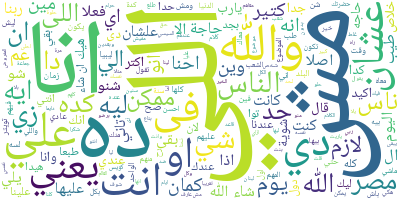

In [24]:
from ar_wordcloud import ArabicWordCloud

text = " ".join(i for i in df.clean_tweet)
awc = ArabicWordCloud(background_color="white")
awc.from_text(text).to_image()

In [25]:
from sklearn.model_selection import train_test_split

X = df["clean_tweet"].astype('U').values.tolist()
y = df["dialect"].astype('U').values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,3))
#corpus = vectorizer_tfidf.fit_transform(corpus.apply(lambda x: np.str_(x)))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

In [114]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def evaluate_model(model, X_test, y_test,model_type=None):
  """ Evaluates a model on test data

  Args:
    model: The model to evaluate.
    test_data: The test data.

  Returns:
    The accuracy score and f1 macro score.

  """
  if model_type == 'DL':
        loss, accuracy = model.evaluate(X_test,y_test)
        probabilites = model.predict(X_test)
        predictions = probabilites.argmax(axis=-1)
        y_test = y_test.argmax(axis=-1)
  else:
      # Make predictions on the test data.
      predictions = model.predict(X_test)

      # Calculate the accuracy score.
      accuracy = accuracy_score(y_test, predictions)

  # Calculate the f1 macro score.
  f1_macro = f1_score(y_test, predictions, average="macro")

  # Print the results.
  print("Accuracy:", accuracy)
  print("F1 macro:", f1_macro)

  report = metrics.classification_report(y_test, predictions)
  print(report)

  return accuracy, f1_macro, report


In [240]:
import pickle
import keras
def save_model(model, filename, mode=None):
  """Saves a model to a .pkl file.

  Args:
    model: The model to save.
    filename: The name of the file to save the model to.

  """
  if mode == 'DL':
        model.save(filename)
  else:
      with open(filename, "wb") as f:
        pickle.dump(model, f)

def load_model(filename,mode=None):
  """Loads a model from a .pkl file.

  Args:
    filename: The name of the file to load the model from.

  Returns:
    The loaded model.

  """
  if mode == 'DL':
        model = keras.models.load_model(filename)
  else:     
      with open(filename, "rb") as f:
        model = pickle.load(f)

  return model


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

classifier_tfidf_NB = MultinomialNB()
model_tfidf_NB = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf_NB)])

model_tfidf_NB.fit(X_train, y_train)

In [ ]:
accuracy, f1_macro, report = evaluate_model(model_tfidf_NB, X_test, y_test)
save_model(model_tfidf_NB,'NB.pkl')

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from nltk.classify import SklearnClassifier

classifier_tfidf_SVC = LinearSVC()
#classifier_tfidf_SVC = SVC(kernel='linear',probability=True)
#classifier_tfidf_SVC = SklearnClassifier(SVC(kernel='linear',probability=True))

model_tfidf_SVC = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf_SVC)])

model_tfidf_SVC.fit(X_train, y_train)

In [ ]:
accuracy, f1_macro, report = evaluate_model(model_tfidf_SVC, X_test, y_test)
#save_model(model_tfidf_SVC,'SVC.pkl')

In [221]:
one_hot_repr = to_categorical([0,1,2,3])

In [225]:
encoder.inverse_transform([2])

array(['LY'], dtype='<U2')

In [231]:
from tensorflow.keras.utils import to_categorical

def classify_sentence(model, sentence, model_type=None,max_seq_length=None,encoder_type=None,encoder=None):
  """Classifies a sentence using a model.

  Args:
    model: The model to use for classification.
    sentence: The sentence to classify.

  Returns:
    A tuple of the predicted label and the predicted probabilities for each class.

  """
  if model_type == 'DL' and max_seq_length != None:
        tokenized_tweet = tokenize_and_pad_tweet(sentence,max_seq_length)
        probabilities_array = model.predict(tokenized_tweet)
        predicted_probabilities = probabilities_array.tolist()[0]
        predicted_label = probabilities_array.argmax(axis=-1)
        one_hot_repr = (probabilities_array == probabilities_array.max(axis=1)[:,None]).astype(int)
        if encoder_type == 'onehot':
            predicted_dialect = encoder.inverse_transform(one_hot_repr)[0]
            print(f"predicted Dialect is {predicted_dialect[0]} \n")
            for i in range(len(encoder.categories_[0])):
                print(f"predicted Dialect {encoder.categories_[0][i]} with probability {predicted_probabilities[i]*100} \n")
        elif encoder_type == 'label':
            predicted_dialect = encoder.inverse_transform([predicted_label])
            print(f"predicted Dialect is {predicted_dialect[0]} \n")         
            for i in range(len(encoder.classes_)):
                print(f"predicted Dialect {encoder.classes_[i]} with probability {predicted_probabilities[i]*100} \n")         
                    
  else:
      # Make a prediction.
      predicted_label = model.predict([sentence])
      print(f"predicted Dialect is {predicted_label[0]} \n")

      # Get the predicted probabilities for each class.
      predicted_probabilities = None
      try:
        predicted_probabilities = model.predict_proba([sentence]).tolist()[0]
        for i in range(len(model.classes_)):
          print(f"predicted Dialect {model.classes_[i]} with probability {predicted_probabilities[i]*100} \n")

      except AttributeError:
        print("Model doesn't support predicting probabilites")

  return predicted_label, predicted_probabilities


In [ ]:
predicted_label, predicted_probabilities = classify_sentence(model_tfidf_SVC,'اسمي احمد')

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tkseem as tk


def tokenize_and_pad_tweets(data,datatype= 'train',max_words=None,max_seq_len=None,model_path= './tokenizer_model.pkl'):
    """Tokenizes tweets and pads the sequences to the length of the longest sequence in the dataset.

    Args:
        df_column (pandas.Series): A DataFrame column containing tweets.

    Returns:
        tuple:
            numpy.ndarray: An array of padded sequences.
            int: The vocabulary size.
            int: The maximum sequence length.
            Tokenizer: The tokenizer object used for the tokenization.
    """
    if max_words == None:
          tokenizer = tk.WordTokenizer()
    else:
          tokenizer = tk.WordTokenizer(vocab_size=max_words)
            
    if datatype == 'train':
        # Create tokenizer 
        path = './tokenizer.txt'
        df = pd.DataFrame(data,columns=['tweet'])
        df.to_csv(path, sep='\n', header=False,index=False)

        tokenizer.train(path)
        
        sequences = [tokenizer.encode(sentence) for sentence in data]
        max_seq_len = max(len(seq) for seq in sequences)
        
        vocab_size = tokenizer.vocab_size
        sequences = pad_sequences(sequences, maxlen=max_seq_len,value = 0, padding='post')
         
    
        tokenizer.save_model('./tokenizer_model.pkl')
    
    elif datatype == 'test' and max_seq_len != None:
        try:
            tokenizer.load_model(model_path)
            sequences = [tokenizer.encode(sentence) for sentence in data]
            vocab_size = tokenizer.vocab_size
            sequences = pad_sequences(sequences, maxlen=max_seq_len,value = 0, padding='post')
            
        except:
            print("please check if tokenizer model is passed correctly!")
    
    return sequences, vocab_size, max_seq_len, tokenizer

In [27]:
train_padded_sequences, vocab_size, max_seq_length, tokenizer = tokenize_and_pad_tweets(X_train,'train')

Training WordTokenizer ...
Saving as pickle file ...


In [34]:
test_padded_sequences, vocab_size, max_seq_length, tokenizer = tokenize_and_pad_tweets(X_test,'test',None,max_seq_length,'./tokenizer_model.pkl')

Loading as pickle file ...


In [226]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical

#creating instance of one-hot-encoder
#encoder = OneHotEncoder(handle_unknown='ignore')

#train_labels = encoder.fit_transform(pd.DataFrame(y_train)).toarray()
#test_labels = encoder.fit_transform(pd.DataFrame(y_test)).toarray()

encoder = LabelEncoder()
train_labels = encoder.fit_transform(y_train)
train_labels = to_categorical(train_labels)
test_labels = encoder.transform(y_test)
test_labels = to_categorical(test_labels)

In [227]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

embedding_dim = 64
rnn_units = 64
# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
model.add(SimpleRNN(units=rnn_units))
model.add(Dense(64, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [228]:
history = model.fit(train_padded_sequences, train_labels, epochs=10, batch_size=64,
                    validation_data=(test_padded_sequences,test_labels))

Epoch 1/10
2077/2077 [==============================] - 28s 13ms/step - loss: 1.4558 - accuracy: 0.3902 - val_loss: 1.4530 - val_accuracy: 0.3902
Epoch 2/10
2077/2077 [==============================] - 27s 13ms/step - loss: 1.4558 - accuracy: 0.3902 - val_loss: 1.4497 - val_accuracy: 0.3902
Epoch 3/10
2077/2077 [==============================] - 29s 14ms/step - loss: 1.4210 - accuracy: 0.4005 - val_loss: 1.3863 - val_accuracy: 0.4335
Epoch 4/10
2077/2077 [==============================] - 28s 14ms/step - loss: 1.4121 - accuracy: 0.4193 - val_loss: 1.4249 - val_accuracy: 0.4095
Epoch 5/10
2077/2077 [==============================] - 29s 14ms/step - loss: 1.4142 - accuracy: 0.4206 - val_loss: 1.4272 - val_accuracy: 0.4090
Epoch 6/10
2077/2077 [==============================] - 28s 13ms/step - loss: 1.4141 - accuracy: 0.4207 - val_loss: 1.4248 - val_accuracy: 0.4093
Epoch 7/10
2077/2077 [==============================] - 27s 13ms/step - loss: 1.4043 - accuracy: 0.4231 - val_loss: 1.4013 -

In [243]:
accuracy, f1_macro, report = evaluate_model(loaded_model, test_padded_sequences, test_labels,'DL')

462/462 [==============================] - 1s 2ms/step
Accuracy: 0.4240146279335022
F1 macro: 0.23445272934943623
              precision    recall  f1-score   support

           0       0.47      0.78      0.59      5762
           1       0.31      0.43      0.36      2762
           2       0.43      0.15      0.22      3648
           3       0.00      0.00      0.00      1154
           4       0.00      0.00      0.00      1440

    accuracy                           0.42     14766
   macro avg       0.24      0.27      0.23     14766
weighted avg       0.35      0.42      0.35     14766



/Users/amrmohamed/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amrmohamed/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amrmohamed/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [237]:
save_model(model, './rnn','DL')

INFO:tensorflow:Assets written to: ./rnn/assets


INFO:tensorflow:Assets written to: ./rnn/assets


In [242]:
loaded_model =load_model('./rnn','DL')

In [117]:
from tensorflow.keras.layers import Bidirectional,LSTM

embedding_dim = 64
lstm_units = 64

# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dense(64, activation='relu'))
model.add(Dense(units=5, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [118]:
history = model.fit(train_padded_sequences, train_labels, epochs=10, batch_size=64,
                    validation_data=(test_padded_sequences,test_labels))

Epoch 1/10
2077/2077 [==============================] - 89s 42ms/step - loss: 0.2460 - accuracy: 0.7246 - val_loss: 0.1908 - val_accuracy: 0.7907
Epoch 2/10
2077/2077 [==============================] - 90s 43ms/step - loss: 0.1729 - accuracy: 0.8144 - val_loss: 0.1883 - val_accuracy: 0.7940
Epoch 3/10
2077/2077 [==============================] - 83s 40ms/step - loss: 0.1570 - accuracy: 0.8323 - val_loss: 0.1914 - val_accuracy: 0.7940
Epoch 4/10
2077/2077 [==============================] - 92s 44ms/step - loss: 0.1441 - accuracy: 0.8464 - val_loss: 0.2003 - val_accuracy: 0.7924
Epoch 5/10
2077/2077 [==============================] - 98s 47ms/step - loss: 0.1319 - accuracy: 0.8588 - val_loss: 0.2039 - val_accuracy: 0.7875
Epoch 6/10
2077/2077 [==============================] - 93s 45ms/step - loss: 0.1199 - accuracy: 0.8720 - val_loss: 0.2195 - val_accuracy: 0.7869
Epoch 7/10
2077/2077 [==============================] - 95s 46ms/step - loss: 0.1089 - accuracy: 0.8835 - val_loss: 0.2473 -

In [116]:
accuracy, f1_macro, report = evaluate_model(model, test_padded_sequences, test_labels,'DL')

462/462 [==============================] - 3s 6ms/step
Accuracy: 0.7660842537879944
F1 macro: 0.7273503632163899
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      5762
           1       0.80      0.79      0.79      2762
           2       0.72      0.75      0.74      3648
           3       0.66      0.66      0.66      1154
           4       0.63      0.61      0.62      1440

    accuracy                           0.77     14766
   macro avg       0.73      0.73      0.73     14766
weighted avg       0.77      0.77      0.77     14766



In [133]:
def tokenize_and_pad_tweet(tweet,max_seq_len=None,model_path= './tokenizer_model.pkl',max_words=None):

    if max_words == None:
          tokenizer = tk.WordTokenizer()
    else:
          tokenizer = tk.WordTokenizer(vocab_size=max_words)

    if tweet != '' and max_seq_len != None:
        try:
            tokenizer.load_model(model_path)
            sequence = tokenizer.encode(tweet)
            vocab_size = tokenizer.vocab_size
            sequence = pad_sequences([sequence], maxlen=max_seq_len,value = 0, padding='post')[0]
            sequence = np.expand_dims(sequence, axis=0)
        except:
            print("please check your tweet and if tokenizer model is passed correctly!")
    
    return sequence

In [134]:
tokenized_tweet = tokenize_and_pad_tweet('انا مصري',max_seq_length)


Loading as pickle file ...


In [201]:
predicted_label, predicted_probabilities = classify_sentence(model, 'اسمي احمد','DL',max_seq_length,'onehot',encoder)

Loading as pickle file ...
1/1 [==============================] - 0s 14ms/step
predicted Dialect is ['SD'] 

predicted Dialect EG with probability 6.365504860877991 

predicted Dialect LB with probability 13.067483901977539 

predicted Dialect LY with probability 2.880878560245037 

predicted Dialect MA with probability 10.309519618749619 

predicted Dialect SD with probability 74.17150735855103 



In [232]:
predicted_label, predicted_probabilities = classify_sentence(model, 'اسمي احمد','DL',max_seq_length,'label',encoder)

Loading as pickle file ...
1/1 [==============================] - 0s 12ms/step
predicted Dialect is EG 

predicted Dialect EG with probability 37.27744817733765 

predicted Dialect LB with probability 19.194912910461426 

predicted Dialect LY with probability 25.164949893951416 

predicted Dialect MA with probability 8.274728059768677 

predicted Dialect SD with probability 10.087963938713074 



/Users/amrmohamed/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
